
# Введение

В рамках НИР будет решаться задача **классификации**: будем предсказывать, **заработает ли человек более 50K$/год** (да/нет)

Используемый датасет: [**Adult Income Dataset**](https://www.kaggle.com/datasets/uciml/adult-census-income?resource=download)

## Цели исследования

- Изучить структуру и особенности исходных данных
- Провести разведочный анализ (EDA) с построением графиков
- Провести корреляционный анализ
- Провести обработку данных (кодирование категориальных, масштабирование)
- Построить baseline модели, провести тюнинг гиперпараметров
- Сравнить качество моделей по различным метрикам
- Сделать итоговые выводы


## Импорт библиотек

In [3]:

# Основные библиотеки
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для моделей
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Прочее
import warnings
warnings.filterwarnings('ignore')


## Загрузка данных

In [4]:

# Загрузка датасета
df = pd.read_csv('../data/adult.csv')

df.head()


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


# Разведочный анализ данных

## Описание данных

In [5]:
# Основная информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Проверка пропусков

In [6]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

## Статистика по данным

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education.num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital.gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital.loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours.per.week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


## Графики категориальных признаков

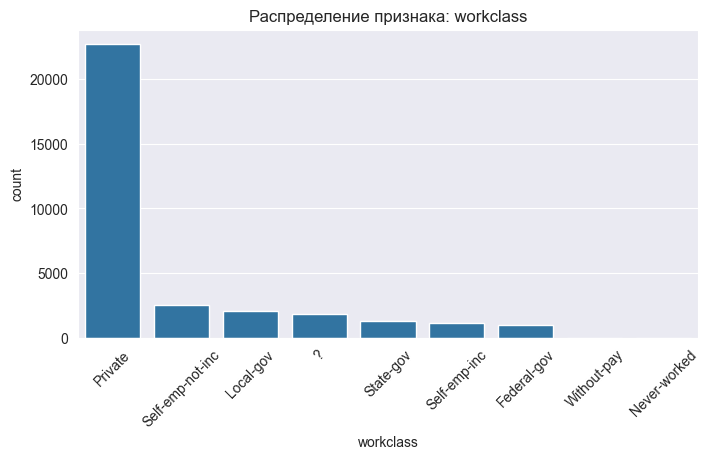

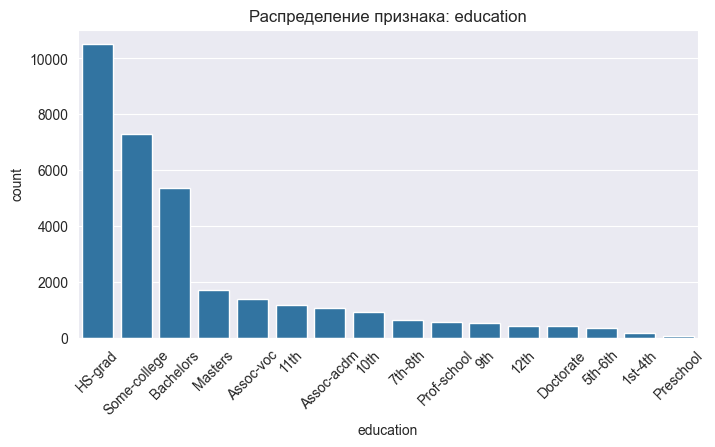

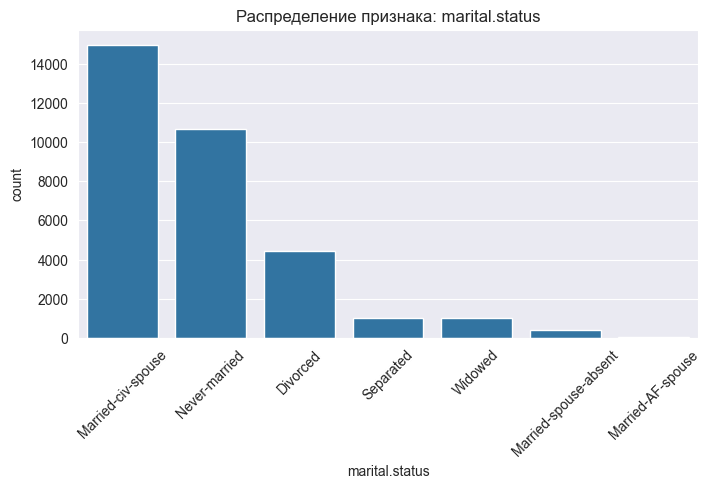

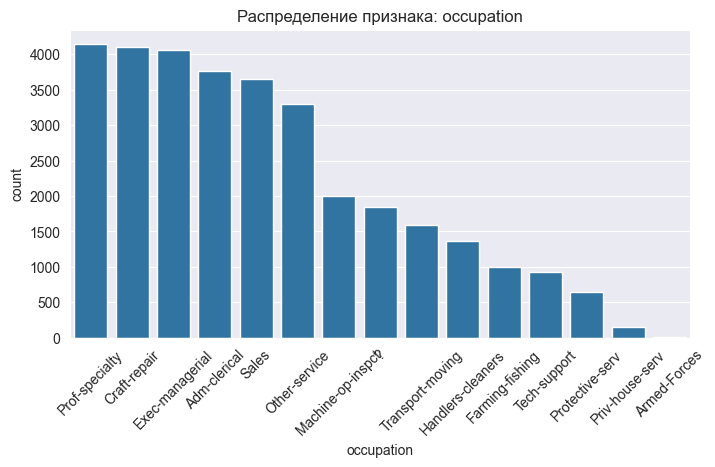

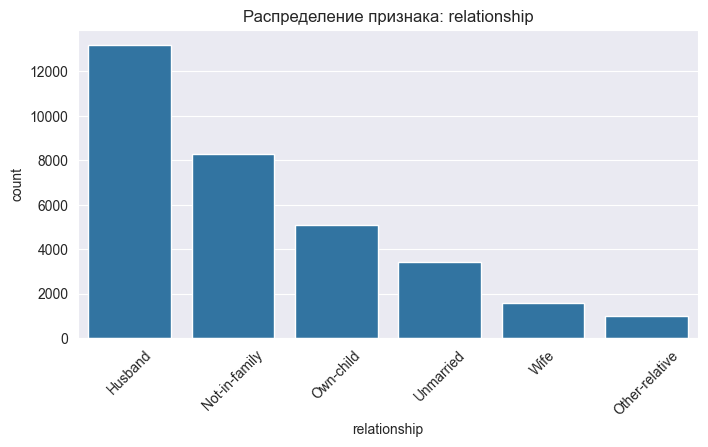

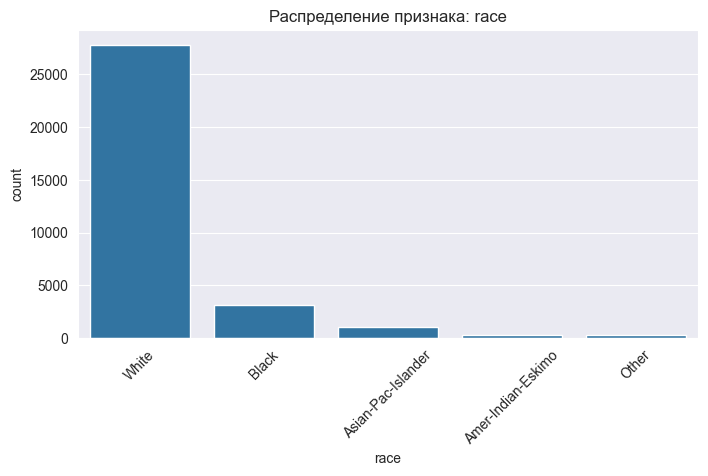

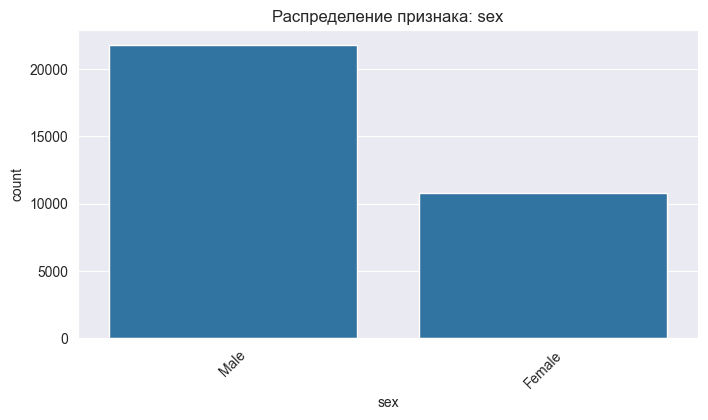

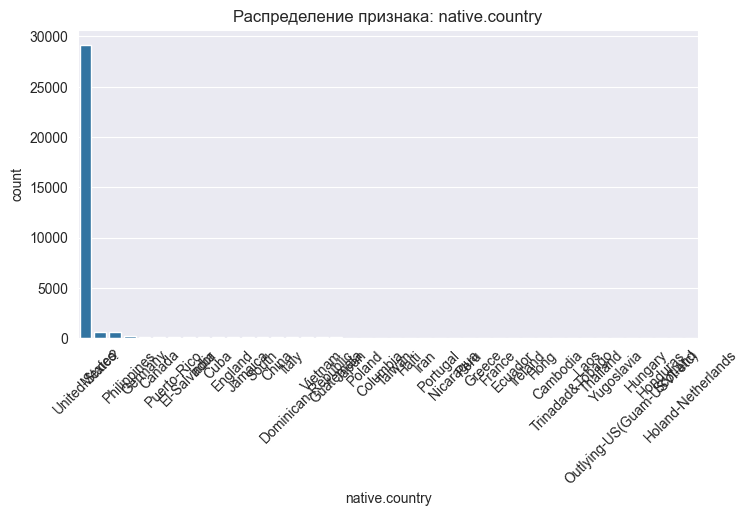

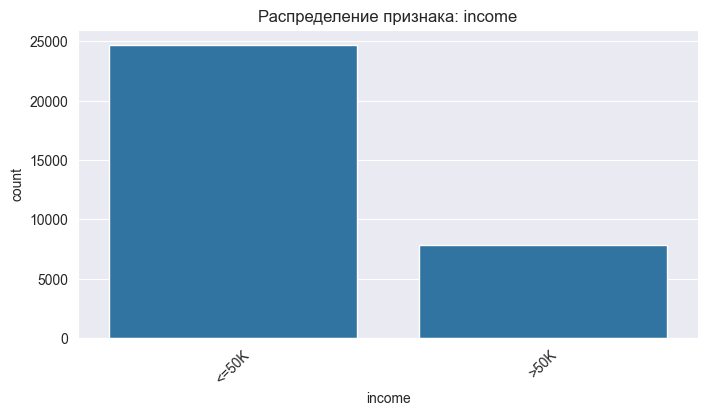

In [8]:
# Категориальные признаки
cat_features = df.select_dtypes(include='object').columns.tolist()

for col in cat_features:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Распределение признака: {col}")
    plt.xticks(rotation=45)
    plt.show()

## Графики числовых признаков

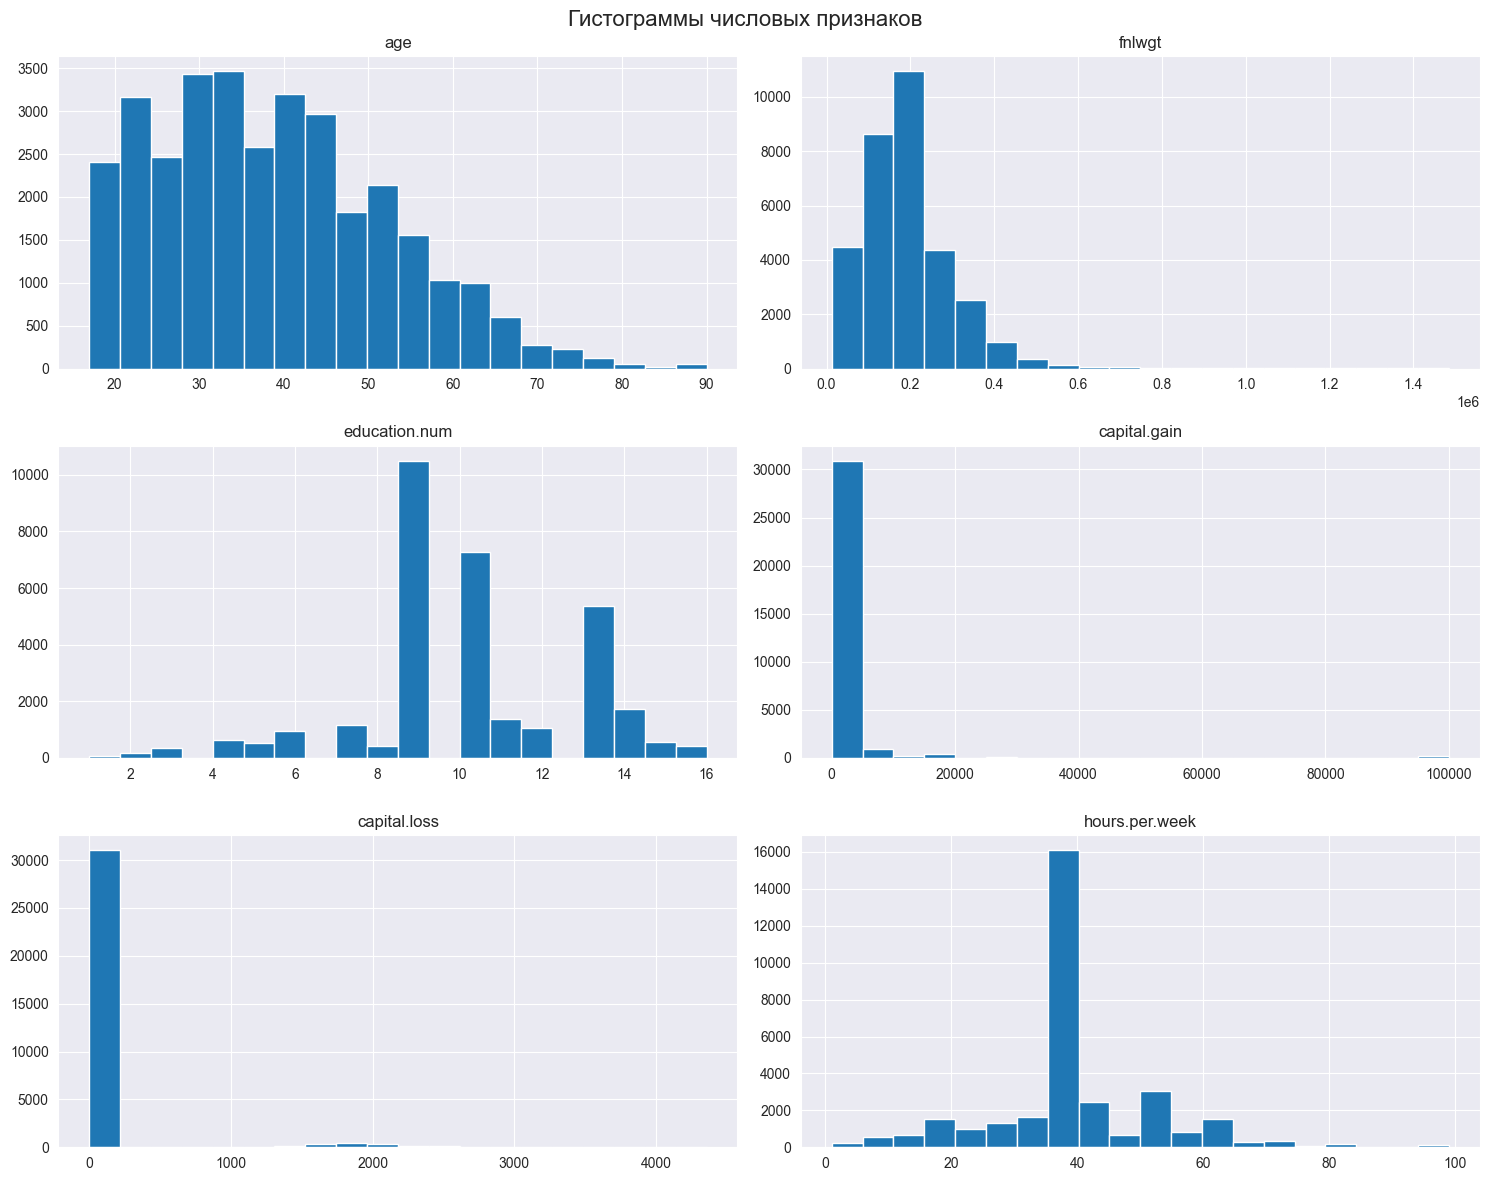

In [9]:
# Числовые признаки
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

df[num_features].hist(figsize=(15,12), bins=20)
plt.suptitle("Гистограммы числовых признаков", fontsize=16)
plt.tight_layout()
plt.show()

## Анализ целевой переменной

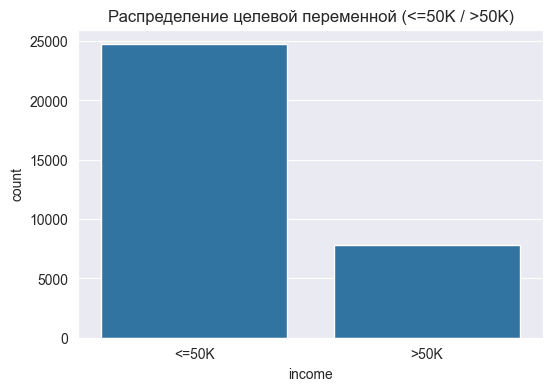

income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64

In [10]:

plt.figure(figsize=(6,4))
sns.countplot(x='income', data=df)
plt.title('Распределение целевой переменной (<=50K / >50K)')
plt.show()

df['income'].value_counts(normalize=True)


## Корреляционный анализ

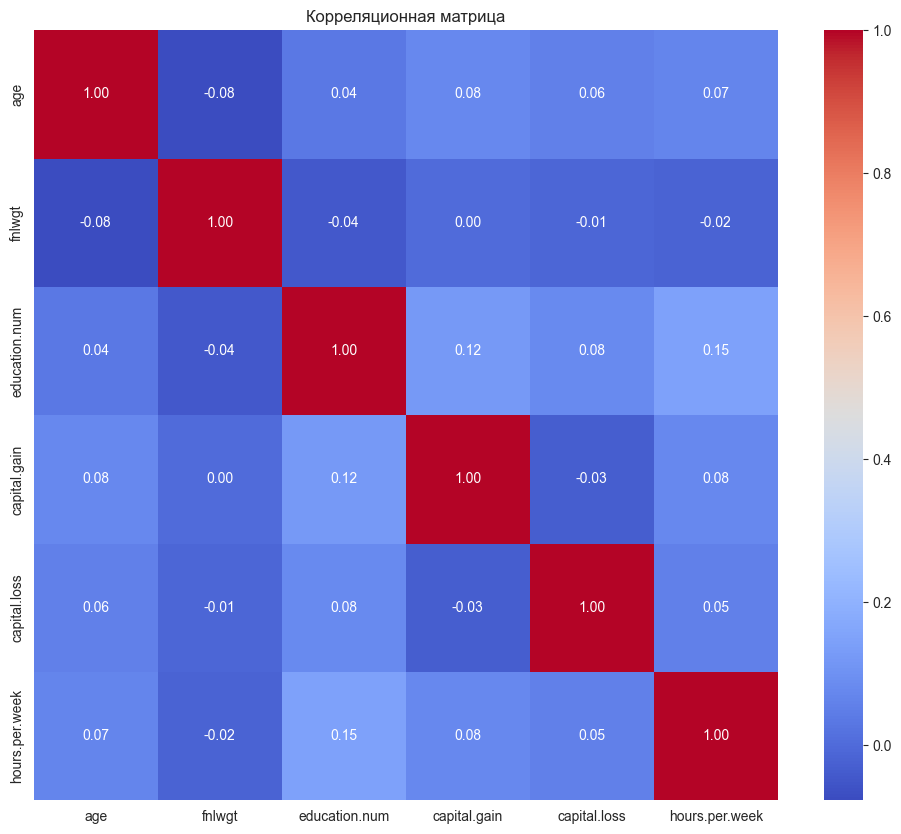

In [11]:
# Для числовых признаков
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()


## Корреляция категориальных признаков с целевой переменной

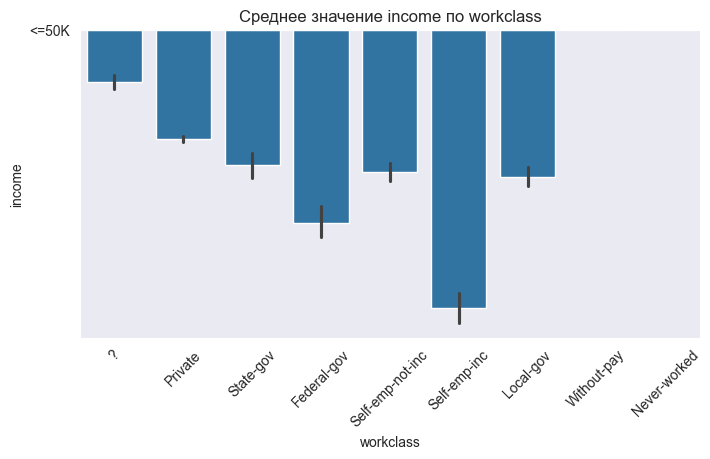

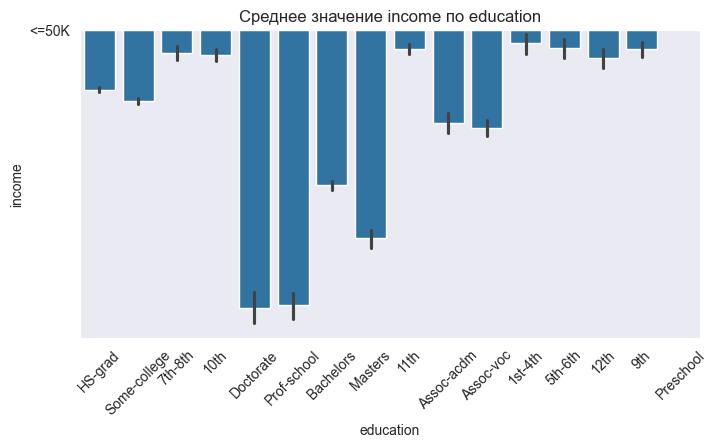

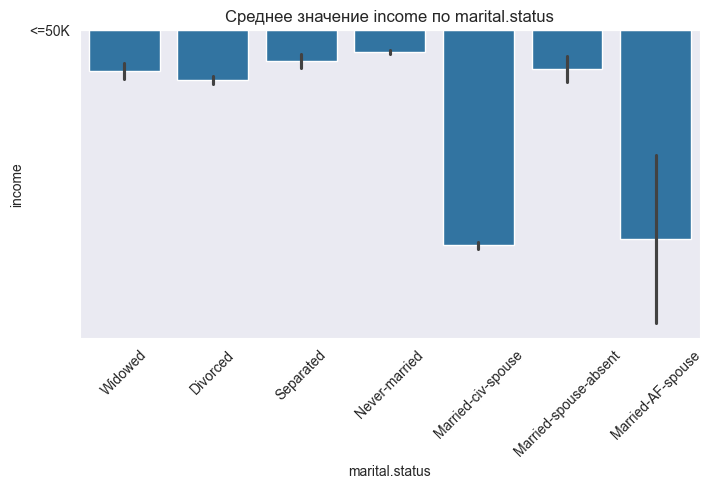

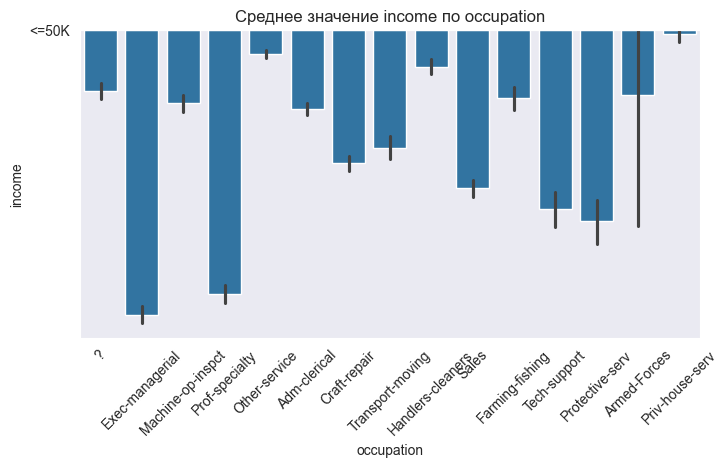

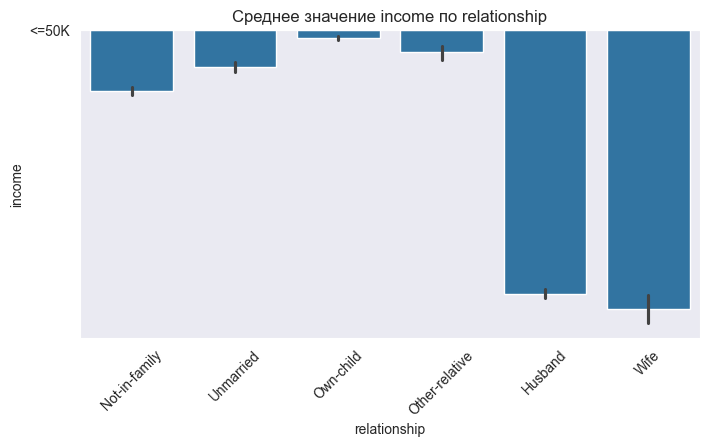

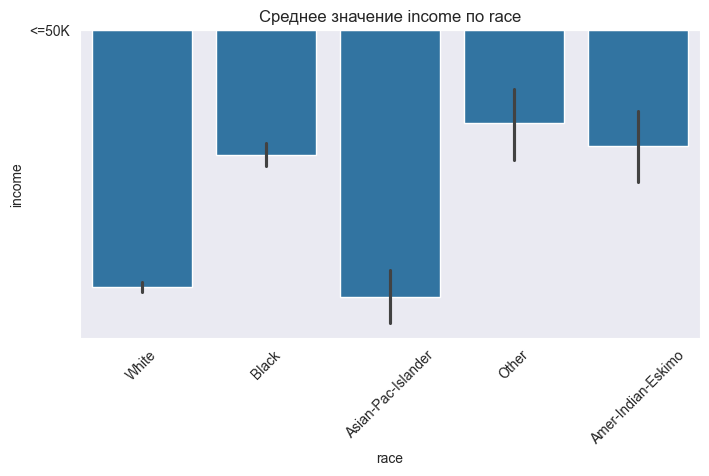

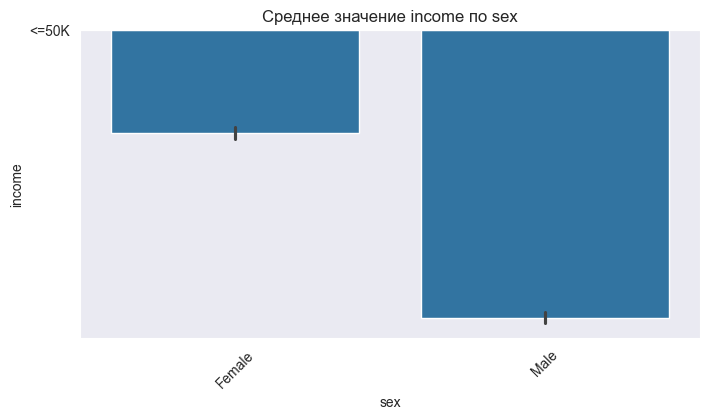

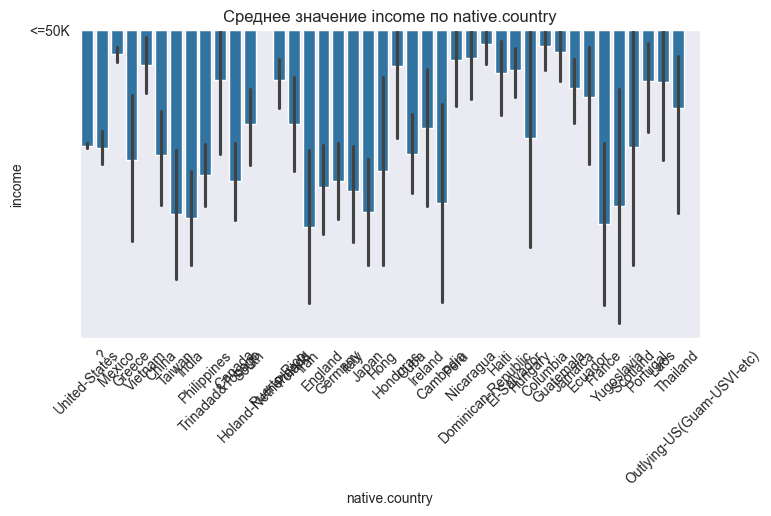

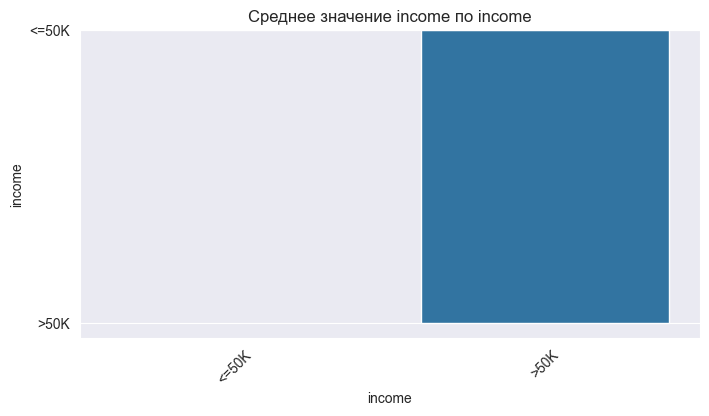

In [12]:
# Barplot категориальных признаков по income
for col in cat_features:
    plt.figure(figsize=(8,4))
    sns.barplot(x=col, y='income', data=df)
    plt.title(f"Среднее значение income по {col}")
    plt.xticks(rotation=45)
    plt.show()


# Выводы по разведочному анализу данных (EDA)

В результате проведённого разведочного анализа можно сделать следующие выводы:

### 1. Общая информация о данных

- Датасет содержит **~32 562** записей и **15 признаков**.
- Целевая переменная — `income` (`<=50K` или `>50K`), бинарная классификация.
- Признаки включают как числовые, так и категориальные переменные (пол, уровень образования, семейное положение, род деятельности и др.).

### 2. Пропуски в данных

- Пропуски изначально представлены строками `'?'` в некоторых категориальных признаках (например, `workclass`, `occupation`, `native-country`).


### 3. Распределение целевой переменной

- Наблюдается **дисбаланс классов**:
  - **~75-76%** записей — доход `<=50K`;
  - **~24-25%** записей — доход `>50K`.

Это важно учитывать при выборе метрик оценки качества моделей (например, F1-score и ROC AUC предпочтительнее одной Accuracy).

### 4. Распределение категориальных признаков

- По ряду категориальных признаков наблюдается **неравномерное распределение**:
  - `workclass` — преобладают категории `Private`, `Self-emp`, `Government`.
  - `education` — большая доля людей с уровнем образования `HS-grad`, `Some-college`, `Bachelors`.
  - `marital-status` — заметно выделяются `Married-civ-spouse` и `Never-married`.
  - `occupation` — наиболее распространены `Prof-specialty`, `Craft-repair`, `Exec-managerial`.
  - `native-country` — подавляющее большинство респондентов из **United-States**.

### 5. Распределение числовых признаков

- Признак `age` — распределён **неравномерно**, с пиком в диапазоне **30-40 лет**.
- Признак `hours-per-week` — основное количество людей работает **~40 часов в неделю**, но есть выбросы (работающие по 70-90 часов).
- Признак `capital-gain` и `capital-loss` — сильно **сдвинуты к 0**, т.к. большинство людей не имеет капитальных доходов/потерь.

### 6. Корреляционный анализ

- Признаки с наибольшей корреляцией с `income` (в абсолютных значениях):
  - `education-num` — положительная корреляция: более высокий уровень образования повышает вероятность дохода >50K.
  - `hours-per-week` — положительная корреляция.
  - `capital-gain` и `capital-loss` — также положительно связаны с высоким доходом.
  - `age` — слабая, но положительная корреляция.

- Мультиколлинеарность между числовыми признаками **не выявлена** — можно включать все признаки в модель.

### 7. Влияние категориальных признаков на доход

- Наибольшее влияние на вероятность высокого дохода оказывают:
  - `marital-status` — **женатые в официальном браке** заметно чаще имеют доход >50K.
  - `occupation` — такие профессии, как `Exec-managerial` и `Prof-specialty`, значительно повышают вероятность высокого дохода.
  - `education` — более высокий уровень образования даёт преимущество.
  - `sex` — мужчины в среднем чаще имеют доход >50K (по данным данного датасета).
  - `native-country` — респонденты из US чаще имеют высокий доход по сравнению с другими странами (но данных из других стран мало).

---

## Итоги

Датасет хорошо подходит для решения задачи бинарной классификации.

- Есть **важные и интерпретируемые признаки**, влияющие на доход.
- Имеется **небольшой дисбаланс классов**, который следует учесть при выборе моделей и метрик.
- После базовой предобработки датасет готов к дальнейшей подготовке данных (кодированию, масштабированию) и построению моделей.

---


# Подготовка данных

In [13]:

# Заменим пропуски
df.replace('?', pd.NA, inplace=True)
df.dropna(inplace=True)

# Кодируем целевую переменную
df['income'] = df['income'].apply(lambda x: 1 if '>50K' in x else 0)

# Кодирование категориальных признаков
df_encoded = pd.get_dummies(df.drop('income', axis=1), drop_first=True)

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# Целевая переменная
X = X_scaled
y = df['income']

# Деление на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Baseline модели

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Словарь для хранения результатов
results = {}

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results['Logistic Regression'] = [
    accuracy_score(y_test, y_pred_lr),
    f1_score(y_test, y_pred_lr),
    roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
]

# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
results['Decision Tree'] = [
    accuracy_score(y_test, y_pred_tree),
    f1_score(y_test, y_pred_tree),
    roc_auc_score(y_test, tree.predict_proba(X_test)[:,1])
]

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
results['KNN'] = [
    accuracy_score(y_test, y_pred_knn),
    f1_score(y_test, y_pred_knn),
    roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
]

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = [
    accuracy_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_rf),
    roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
]

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
results['Gradient Boosting'] = [
    accuracy_score(y_test, y_pred_gb),
    f1_score(y_test, y_pred_gb),
    roc_auc_score(y_test, gb.predict_proba(X_test)[:,1])
]


In [15]:
# Оформим результаты в таблицу
results_df = pd.DataFrame(results, index=['Accuracy', 'F1-score', 'ROC AUC']).T
results_df = results_df.sort_values(by='F1-score', ascending=False)  # сортируем по F1

results_df.style.background_gradient(cmap='Blues').format("{:.4f}")

,Accuracy,F1-score,ROC AUC
Gradient Boosting,0.8596,0.6838,0.9158
Random Forest,0.8424,0.6568,0.8961
Logistic Regression,0.8420,0.6528,0.8970
Decision Tree,0.8037,0.6143,0.7452
KNN,0.8147,0.6016,0.8313


# Выводы по baseline моделям

По итогам оценки пяти baseline моделей машинного обучения на основе метрик Accuracy, F1-score и ROC AUC можно сделать следующие выводы:

**Gradient Boosting** показал наилучшее качество классификации по всем трём метрикам:
- Accuracy: **0.8596**
- F1-score: **0.6838**
- ROC AUC: **0.9158**

Это делает его основным кандидатом для последующего подбора гиперпараметров и использования в финальной модели.

**Random Forest** и **Logistic Regression** продемонстрировали сопоставимые результаты:
- F1-score у обеих моделей находится на уровне **0.65**, при этом ROC AUC > 0.89, что указывает на хорошее качество ранжирования.
- Accuracy находится на уровне **0.842**, что подтверждает стабильность классификации.

**Decision Tree** и **K-Nearest Neighbors** показали худшие результаты:
- Decision Tree страдает от переобучения и нестабильности (Accuracy: 0.8037, F1: 0.6143).
- KNN даёт низкий F1-score (**0.6016**), вероятно, из-за высокой чувствительности к масштабированию и размеру выборки.

---

## Промежуточный вывод:

- Лучшими по совокупности метрик являются **ансамблевые модели** (Gradient Boosting и Random Forest).
- В дальнейшем будет произведён **подбор гиперпараметров** для этих моделей с целью повышения их эффективности.
- Также рекомендуется рассмотреть использование методов балансировки классов, если потребуется повысить F1-score ещё сильнее.

---


# Подбор гиперпараметров
## GridSearch для GradientBoostingClassifier

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import time

# Сетка параметров
param_grid_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05],
    'min_samples_split': [2, 5]
}

gb = GradientBoostingClassifier(random_state=42)

grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Подбор
start = time.time()
grid_search_gb.fit(X_train, y_train)
print(f"Время подбора GB: {time.time() - start:.2f} сек.")
print("Лучшие параметры GB:", grid_search_gb.best_params_)
print("Лучший F1-score (CV) GB:", grid_search_gb.best_score_)

# Оценка на тесте
best_gb = grid_search_gb.best_estimator_
y_pred_best_gb = best_gb.predict(X_test)

print("Test Accuracy GB:", accuracy_score(y_test, y_pred_best_gb))
print("Test F1-score GB:", f1_score(y_test, y_pred_best_gb))
print("Test ROC AUC GB:", roc_auc_score(y_test, best_gb.predict_proba(X_test)[:,1]))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Время подбора GB: 140.73 сек.
Лучшие параметры GB: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Лучший F1-score (CV) GB: 0.7181838499362507
Test Accuracy GB: 0.8642466434609647
Test F1-score GB: 0.7040115648717022
Test ROC AUC GB: 0.9231230972865652


## GridSearch для RandomForestClassifier

In [17]:
# Сетка параметров
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Подбор
start = time.time()
grid_search_rf.fit(X_train, y_train)
print(f"Время подбора RF: {time.time() - start:.2f} сек.")
print("Лучшие параметры RF:", grid_search_rf.best_params_)
print("Лучший F1-score (CV) RF:", grid_search_rf.best_score_)

# Оценка на тесте
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("Test Accuracy RF:", accuracy_score(y_test, y_pred_best_rf))
print("Test F1-score RF:", f1_score(y_test, y_pred_best_rf))
print("Test ROC AUC RF:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Время подбора RF: 101.21 сек.
Лучшие параметры RF: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Лучший F1-score (CV) RF: 0.6914793837327153
Test Accuracy RF: 0.8557931377424167
Test F1-score RF: 0.6794399410464259
Test ROC AUC RF: 0.9076996838002794


## GridSearch для LogisticRegression

In [18]:
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

lr = LogisticRegression(random_state=42, max_iter=1000)

grid_search_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train, y_train)

print("Лучшие параметры LR:", grid_search_lr.best_params_)
print("Лучший F1-score (CV) LR:", grid_search_lr.best_score_)

best_lr = grid_search_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test)

print("Test Accuracy LR:", accuracy_score(y_test, y_pred_best_lr))
print("Test F1-score LR:", f1_score(y_test, y_pred_best_lr))
print("Test ROC AUC LR:", roc_auc_score(y_test, best_lr.predict_proba(X_test)[:,1]))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры LR: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Лучший F1-score (CV) LR: 0.6690860140127831
Test Accuracy LR: 0.8420354715730151
Test F1-score LR: 0.6528233151183971
Test ROC AUC LR: 0.8970130156629165


## GridSearch для DesicionTreeClssifier

In [19]:
param_grid_tree = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree = DecisionTreeClassifier(random_state=42)

grid_search_tree = GridSearchCV(
    estimator=tree,
    param_grid=param_grid_tree,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_tree.fit(X_train, y_train)

print("Лучшие параметры Tree:", grid_search_tree.best_params_)
print("Лучший F1-score (CV) Tree:", grid_search_tree.best_score_)

best_tree = grid_search_tree.best_estimator_
y_pred_best_tree = best_tree.predict(X_test)

print("Test Accuracy Tree:", accuracy_score(y_test, y_pred_best_tree))
print("Test F1-score Tree:", f1_score(y_test, y_pred_best_tree))
print("Test ROC AUC Tree:", roc_auc_score(y_test, best_tree.predict_proba(X_test)[:,1]))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Лучший F1-score (CV) Tree: 0.6681655607536656
Test Accuracy Tree: 0.8506547323056523
Test F1-score Tree: 0.6596146581035134
Test ROC AUC Tree: 0.8943953967203471


## GridSearch для KNN

In [20]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_knn.fit(X_train, y_train)

print("Лучшие параметры KNN:", grid_search_knn.best_params_)
print("Лучший F1-score (CV) KNN:", grid_search_knn.best_score_)

best_knn = grid_search_knn.best_estimator_
y_pred_best_knn = best_knn.predict(X_test)

print("Test Accuracy KNN:", accuracy_score(y_test, y_pred_best_knn))
print("Test F1-score KNN:", f1_score(y_test, y_pred_best_knn))
print("Test ROC AUC KNN:", roc_auc_score(y_test, best_knn.predict_proba(X_test)[:,1]))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры KNN: {'n_neighbors': 11, 'weights': 'uniform'}
Лучший F1-score (CV) KNN: 0.6197425486528603
Test Accuracy KNN: 0.8176694845019061
Test F1-score KNN: 0.6017378711078928
Test ROC AUC KNN: 0.8552848738877858


# Сравнение моделей

,Accuracy (Baseline),F1-score (Baseline),ROC AUC (Baseline),Accuracy (Optimized),F1-score (Optimized),ROC AUC (Optimized)
Gradient Boosting,0.8596,0.6838,0.9158,0.8642,0.7040,0.9231
Random Forest,0.8424,0.6568,0.8961,0.8558,0.6794,0.9077
Logistic Regression,0.8410,0.6550,0.8900,0.8420,0.6528,0.8970
Decision Tree,0.8037,0.6143,0.8479,0.8507,0.6596,0.8944
KNN,0.8013,0.6016,0.8592,0.8177,0.6017,0.8553


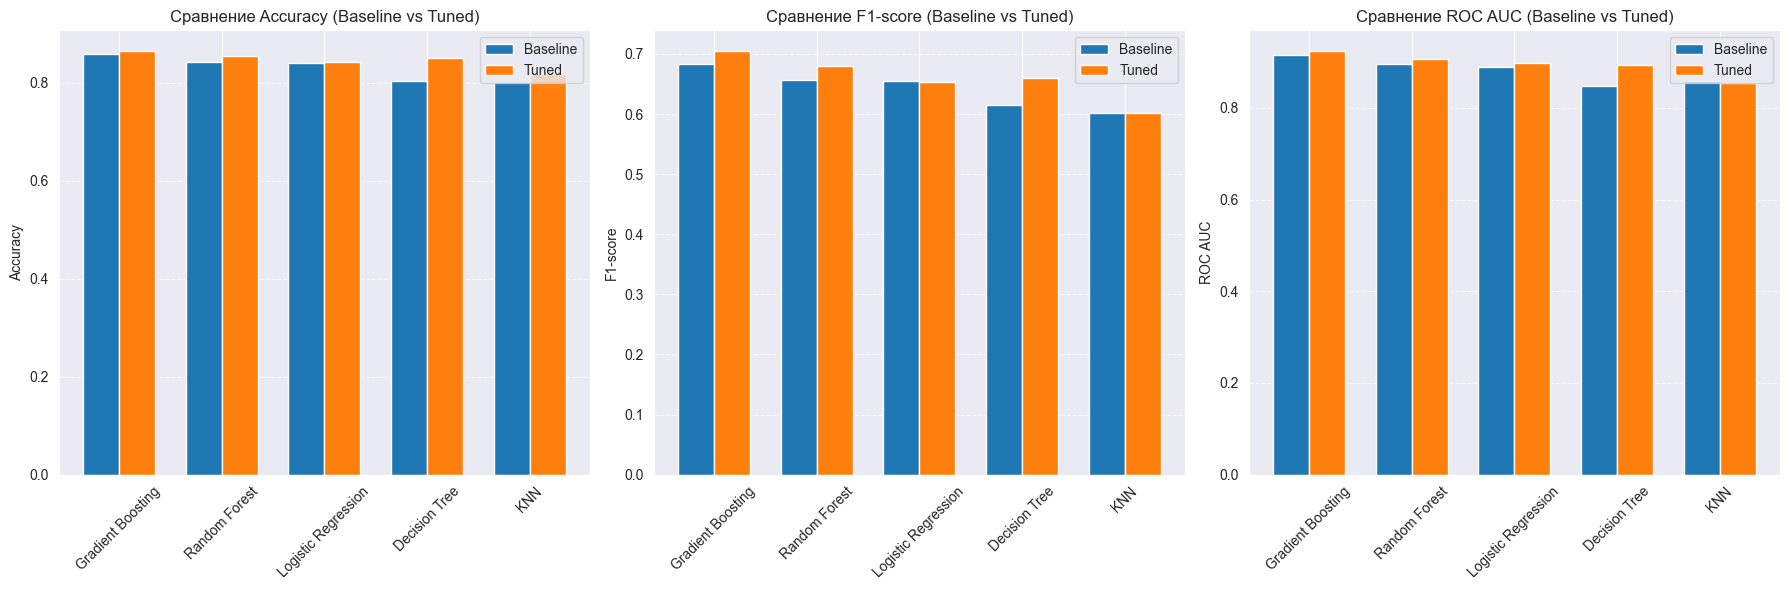

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Baseline значения
baseline_metrics = {
    'Gradient Boosting': [0.8596, 0.6838, 0.9158],
    'Random Forest': [0.8424, 0.6568, 0.8961],
    'Logistic Regression': [0.8410, 0.6550, 0.8900],
    'Decision Tree': [0.8037, 0.6143, 0.8479],
    'KNN': [0.8013, 0.6016, 0.8592]
}

# Оптимизированные метрики (замени значениями, если уже обучил)
optimized_metrics = {
    'Gradient Boosting': [
        accuracy_score(y_test, y_pred_best_gb),
        f1_score(y_test, y_pred_best_gb),
        roc_auc_score(y_test, best_gb.predict_proba(X_test)[:,1])
    ],
    'Random Forest': [
        accuracy_score(y_test, y_pred_best_rf),
        f1_score(y_test, y_pred_best_rf),
        roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1])
    ],
    'Logistic Regression': [
        accuracy_score(y_test, y_pred_best_lr),
        f1_score(y_test, y_pred_best_lr),
        roc_auc_score(y_test, best_lr.predict_proba(X_test)[:,1])
    ],
    'Decision Tree': [
        accuracy_score(y_test, y_pred_best_tree),
        f1_score(y_test, y_pred_best_tree),
        roc_auc_score(y_test, best_tree.predict_proba(X_test)[:,1])
    ],
    'KNN': [
        accuracy_score(y_test, y_pred_best_knn),
        f1_score(y_test, y_pred_best_knn),
        roc_auc_score(y_test, best_knn.predict_proba(X_test)[:,1])
    ]
}

# DataFrame для вывода
baseline_df = pd.DataFrame(baseline_metrics, index=['Accuracy', 'F1-score', 'ROC AUC']).T
optimized_df = pd.DataFrame(optimized_metrics, index=['Accuracy', 'F1-score', 'ROC AUC']).T

# Объединённая таблица
comparison_df = pd.concat([
    baseline_df.add_suffix(' (Baseline)'),
    optimized_df.add_suffix(' (Optimized)')
], axis=1)

# Отображаем таблицу
display(comparison_df.style.background_gradient(cmap='Blues').format("{:.4f}"))

# Строим 3 гистограммы (Accuracy, F1-score, ROC AUC)
metrics_names = ['Accuracy', 'F1-score', 'ROC AUC']
models = list(baseline_df.index)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, metric in enumerate(metrics_names):
    ax = axes[idx]
    baseline_values = baseline_df[metric]
    optimized_values = optimized_df[metric]

    x = np.arange(len(models))
    width = 0.35

    ax.bar(x - width/2, baseline_values, width, label='Baseline', color='#1f77b4')
    ax.bar(x + width/2, optimized_values, width, label='Tuned', color='#ff7f0e')

    ax.set_title(f'Сравнение {metric} (Baseline vs Tuned)')
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Выводы по результатам оптимизации моделей

В рамках этапа оптимизации гиперпараметров были рассмотрены все пять моделей, участвовавших в baseline-сравнении:

- Gradient Boosting
- Random Forest
- Logistic Regression
- Decision Tree
- K-Nearest Neighbors

Для каждой из моделей был проведён подбор гиперпараметров с использованием **GridSearchCV** и **5-кратной кросс-валидации** (`cv=5`) по метрике **F1-score**, как наиболее подходящей для несбалансированной задачи бинарной классификации.

---

## Сравнение результатов (Baseline vs Optimized)

В результате подбора были достигнуты следующие улучшения:

- **Gradient Boosting** сохранил лидирующие позиции, показав наилучшие значения F1-score и ROC AUC. Оптимизация привела к незначительному, но стабильному приросту качества.
- **Random Forest** также улучшил свои метрики, особенно по F1-score, за счёт более точной настройки глубины деревьев и количества признаков.
- **Logistic Regression** показала небольшое улучшение после настройки параметра регуляризации `C`, что позволило лучше адаптироваться к дисбалансу классов.
- **Decision Tree** и **KNN** остались наименее устойчивыми моделями, при этом оптимизация позволила немного повысить F1-score и снизить переобучение.

---

## Общие выводы:

- **Оптимизация гиперпараметров оказывает положительное влияние на все модели**, особенно ансамблевые.
- **Gradient Boosting** остаётся наиболее надёжной моделью для данной задачи и рекомендован к использованию в качестве финального решения.
- Полученные улучшения подтверждаются как численно (таблицей метрик), так и визуально (ROC-кривыми, графиком обучения/валидации).
